## Example of model initialization
The following demos how the current model initialization could be realized in DGL. income function have currently nit been incuded, but should be eventually.
Overall, a model class with a self.graph object on which the operations are performed would be desirable, aso allowing model operatioons to be implemented as class methods.

In [1]:
import os
os.environ["DGLBACKEND"] = "pytorch"

import torch 
import pandas as pd
import dgl
from dgl.data import DGLDataset
import dgl.function as fn
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
import matplotlib.pyplot as plt

import networkx as nx
def plot_net(net,options = None):
    netG = dgl.to_networkx(net)
    plt.figure(figsize=[15,7])
    if options != None:
        nx.draw(netG,**options)
    else:
        nx.draw(netG)

In [28]:
N_agents = 11 #number of agents
m_links = 1 # number of links to initialy establish barabasi-albert graph
sigma_set = 0.5 # set value for sigma

#edge_weights = '1' # value or 'random'

In [4]:
barabasi_albert = nx.barabasi_albert_graph(n=N_agents, m=m_links)

In [5]:
barabasi_albert

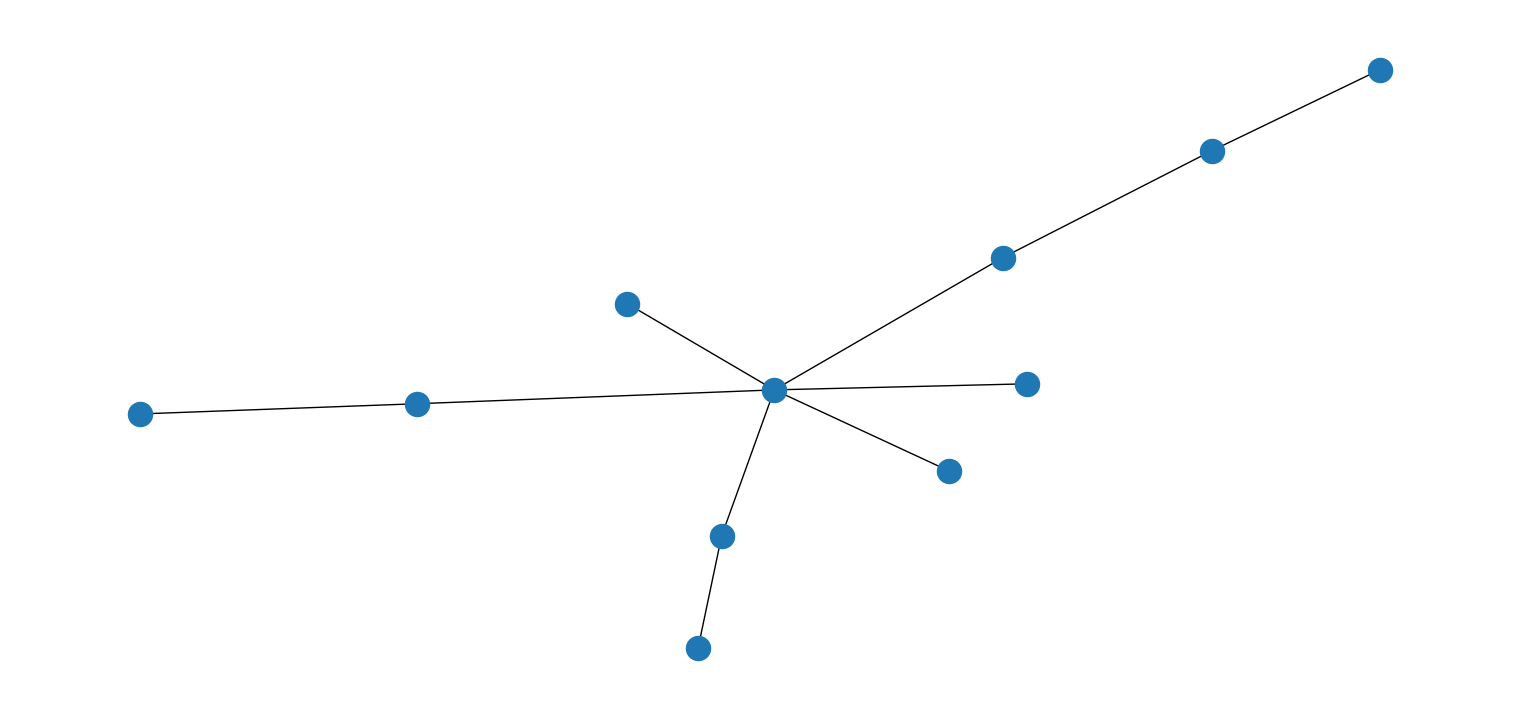

In [6]:
plt.figure(figsize=[15,7])
nx.draw(barabasi_albert)

### Note 
It is possible to coonstruct a dgl graph directly from a networkx graph, however, DGL cautions that this is very time consuming for large graphs, and recommends the use of a tuple of node tensors and a construction using dgl.graph. A COO format sparse scipy representation should be equivalent, with the subsequent use of `from_scipy`. 

In [7]:
ba_coo = nx.to_scipy_sparse_array(barabasi_albert,format='coo')

In [8]:
ba_coo

<11x11 sparse array of type '<class 'numpy.int64'>'
	with 20 stored elements in COOrdinate format>

In [9]:
print(ba_coo)

  (0, 1)	1
  (0, 2)	1
  (0, 3)	1
  (0, 5)	1
  (0, 6)	1
  (0, 9)	1
  (2, 4)	1
  (5, 10)	1
  (6, 7)	1
  (7, 8)	1
  (1, 0)	1
  (2, 0)	1
  (3, 0)	1
  (5, 0)	1
  (6, 0)	1
  (9, 0)	1
  (4, 2)	1
  (10, 5)	1
  (7, 6)	1
  (8, 7)	1


In [10]:
g = dgl.from_scipy(ba_coo,eweight_name='weight')

In [11]:
g

Graph(num_nodes=11, num_edges=20,
      ndata_schemes={}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.int64)})

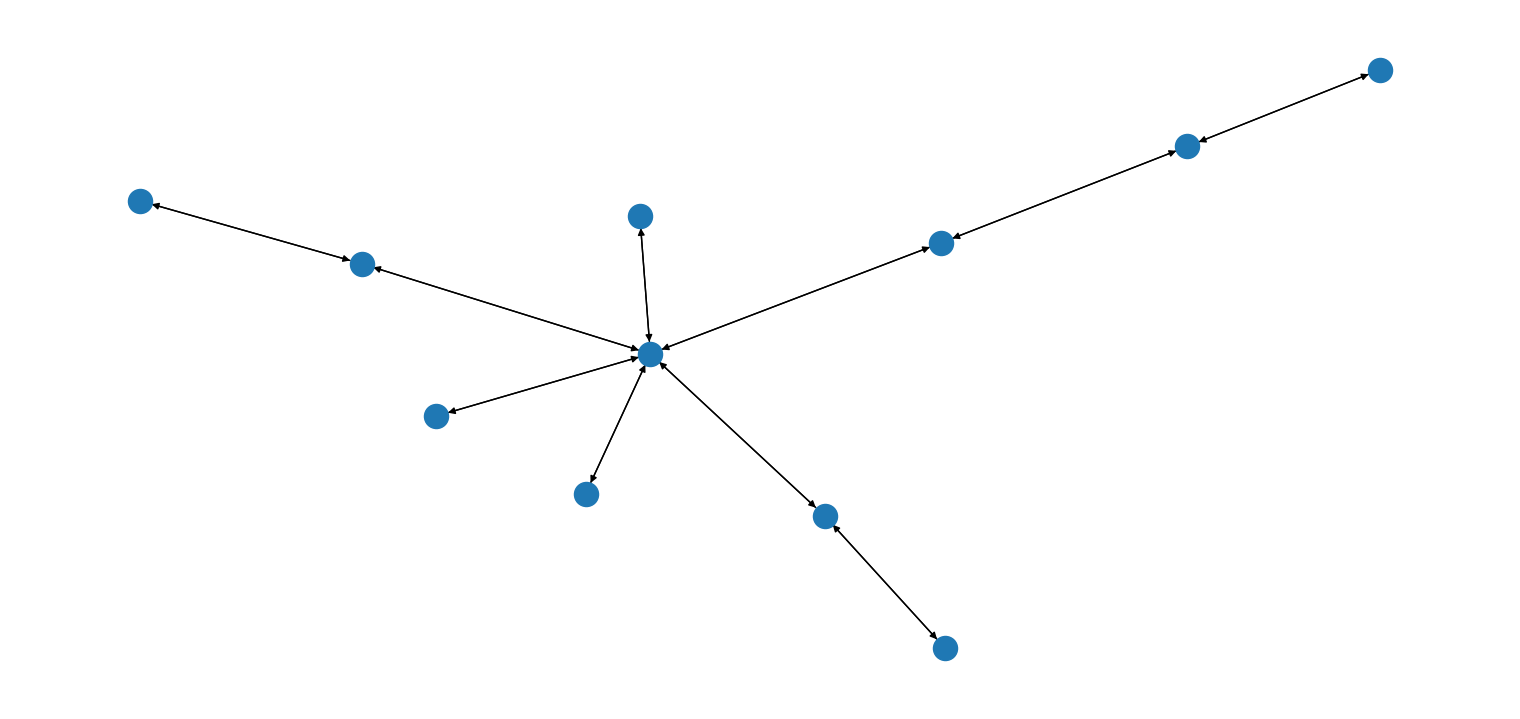

In [12]:
plot_net(g)

In [13]:
g.ndata

{}

In [14]:
g.num_nodes()

11

### set node data

In [15]:
#capital = torch.distributions.uniform.Uniform(torch.tensor([0.1]),torch.tensor([10.])).sample(torch.tensor([N_agents]))
capital = torch.distributions.uniform.Uniform(torch.tensor(0.1),torch.tensor(10.)).sample(torch.tensor([N_agents]))

In [16]:
alpha = torch.distributions.normal.Normal(torch.tensor(1.08),torch.tensor(0.074)).sample(torch.tensor([N_agents]))

In [17]:
lam = torch.round(torch.distributions.uniform.Uniform(torch.tensor(0.1),torch.tensor(0.9)).sample(torch.tensor([N_agents])),decimals=1)

Note: The original code for lambda sampled from the interval 0.1,1. before rouunding to 1 decimal. As a result lambda = 1. was possible. a subsequent loop forced resamplnig in this case, i.e. constraining lambda to the set {0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9}. The implementattioon above achives the same wiithout resampling, by exculuding 1.0 as possible value.

In [29]:
sigma = torch.ones_like(alpha)*sigma_set

In [18]:
type(capital)

torch.Tensor

In [30]:
alpha , capital,lam,sigma

(tensor([1.1445, 1.2398, 1.0409, 1.0992, 1.0314, 1.0315, 1.0852, 0.9833, 1.1288,
         1.1353, 1.0918]),
 tensor([9.4113, 6.0174, 3.3746, 5.0068, 8.5545, 1.0299, 9.9108, 3.1230, 3.2694,
         5.0569, 8.7956]),
 tensor([0.4000, 0.7000, 0.6000, 0.8000, 0.3000, 0.3000, 0.9000, 0.3000, 0.5000,
         0.1000, 0.2000]),
 tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
         0.5000, 0.5000]))

In [22]:
g.ndata["k"] = capital

In [23]:
g.ndata["alpha"] = alpha

In [24]:
g.ndata["lambda"] = lam

In [31]:
g.ndata["sigma"] = sigma

The implementation of tech based specification of gamma and cost must be realized in a different manner than in the PovertyTrap model, as tensors can only have numerical values, and parallel referencinig of an iindex table is also ddiifficult. Here we use the following approach.

a) define a numerical key for tec values: 0 low tech, 1 high tech (cn be expanded to more)

b) initialiize tec distribution, gamma and cost tensors

c) create techh masks

d) set gamma and cost tensors using masks (these must be updated if tec can change value 

In [34]:
tec = torch.distributions.bernoulli.Bernoulli(probs=0.5, logits=None, validate_args=None).sample(torch.tensor([N_agents]))

In [36]:
gamma = torch.zeros_like(sigma)
cost = torch.zeros_like(sigma)

In [39]:
g.ndata["tec"] = tec
g.ndata["gamma"] = gamma
g.ndata["cost"] = cost

In [50]:
gamma_vals = torch.tensor([0.3,0.45])
cost_vals = torch.tensor([0.,0.45])

In [53]:
low_tec_mask = tec == 0
high_tec_mask = tec == 1

In [63]:
g.ndata["gamma"][low_tec_mask]=gamma_vals[0]
g.ndata["cost"][low_tec_mask]=cost_vals[0]
g.ndata["gamma"][high_tec_mask]=gamma_vals[1]
g.ndata["cost"][high_tec_mask]=cost_vals[1]

In [64]:
g.ndata

{'lambda': tensor([0.4000, 0.7000, 0.6000, 0.8000, 0.3000, 0.3000, 0.9000, 0.3000, 0.5000,
        0.1000, 0.2000]), 'k': tensor([9.4113, 6.0174, 3.3746, 5.0068, 8.5545, 1.0299, 9.9108, 3.1230, 3.2694,
        5.0569, 8.7956]), 'alpha': tensor([1.1445, 1.2398, 1.0409, 1.0992, 1.0314, 1.0315, 1.0852, 0.9833, 1.1288,
        1.1353, 1.0918]), 'sigma': tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000]), 'tec': tensor([0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0.]), 'gamma': tensor([0.3000, 0.4500, 0.4500, 0.4500, 0.4500, 0.3000, 0.3000, 0.3000, 0.4500,
        0.4500, 0.3000]), 'cost': tensor([0.0000, 0.4500, 0.4500, 0.4500, 0.4500, 0.0000, 0.0000, 0.0000, 0.4500,
        0.4500, 0.0000])}

In [32]:
g.ndata

{'lambda': tensor([0.4000, 0.7000, 0.6000, 0.8000, 0.3000, 0.3000, 0.9000, 0.3000, 0.5000,
        0.1000, 0.2000]), 'k': tensor([9.4113, 6.0174, 3.3746, 5.0068, 8.5545, 1.0299, 9.9108, 3.1230, 3.2694,
        5.0569, 8.7956]), 'alpha': tensor([1.1445, 1.2398, 1.0409, 1.0992, 1.0314, 1.0315, 1.0852, 0.9833, 1.1288,
        1.1353, 1.0918]), 'sigma': tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000])}

In [26]:
g.edata

{'weight': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])}

## Note: 
The code below enables the removal of nodes. Remaining nodes are REINDEXED. original ids can be retainied using `store_ids`. However, if nodes are subsequently added, the origiinal id field is initialized to zerto bu default, without any relation to previouus node ids. While currenlty not an issue this is prblematiic and requires attention for more general appliications 

In [ ]:
g.remove_nodes(0,store_ids=True)

In [ ]:
g.add_nodes(1)

In [ ]:
g.ndata